# Malaria detection in RBCs  
  
  
Malaria is a deadly, infectious, mosquito-borne disease caused by Plasmodium parasites that are transmitted by the bites of infected female Anopheles mosquitoes. There are five parasites that cause malaria, but two types—P. falciparum and P. vivax—cause the majority of the cases. 
  
There are several methods that can be used for malaria detection and diagnosis. Some methods include polymerase chain reaction (PCR) and rapid diagnostic tests (RDT). These two tests are typically used where high-quality microscopy services are not readily available. According to WHO protocol, diagnosis typically involves intensive examination of the blood smear at 100X magnification. Trained people manually count how many red blood cells contain parasites out of 5,000 cells.  
  
Manual diagnosis of blood smears is an intensive manual process that requires expertise in classifying and counting parasitized and uninfected cells. This process may not scale well, especially in regions where the right expertise is hard to find. 
Deep learning models, or more specifically convolutional neural networks (CNNs), have proven very effective in a wide variety of computer vision tasks. Furthermore, once trained, they are also highly scalable. 
  
Hence, malaria detection could benefit from automation using through learning.

In [1]:
import os
import warnings
import random
import shutil  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# train-test split
# to be run only once
'''
root_dir = 'cell_images'
class_dirs = ['Parasitized','Uninfected']

train_path = os.path.join('data','train')  
test_path = os.path.join('data','test')

test_ratio = 0.10

for class_dir in class_dirs:
    # create directories
    os.makedirs(os.path.join(train_path,class_dir))
    os.makedirs(os.path.join(test_path,class_dir))
    # shuffle images
    src = os.path.join(root_dir,class_dir) 
    file_list = os.listdir(src)
    random.shuffle(file_list)
    threshold = int(len(file_list) * (1 - test_ratio))
    train_files, test_files = file_list[0:threshold], file_list[threshold:]
    # append path to file names
    train_files = [os.path.join(src,name) for name in train_files]
    test_files = [os.path.join(src,name) for name in test_files]
    # Copy-pasting images
    for name in train_files:
        shutil.copy(name, os.path.join(train_path,class_dir))
    for name in test_files:
        shutil.copy(name, os.path.join(test_path,class_dir))
    
    print(f'Total {class_dir} images: ', len(file_list))
    print('Training: ', len(train_files))
    print('Testing: ', len(test_files))
    print()
''';

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = os.path.join('data','train')  
test_path = os.path.join('data','test')
train_datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.1,
                            rotation_range=30,
                            zoom_range=0.15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            horizontal_flip=True,
                            fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen = train_datagen.flow_from_directory(directory=train_path,
                                              target_size=(120,120),
                                              batch_size=32,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='training')

val_gen = train_datagen.flow_from_directory(directory=train_path,
                                            target_size=(120,120),
                                            batch_size=32, 
                                            shuffle=True,
                                            class_mode='binary',
                                            subset='validation')

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                            target_size=(120,120),
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode='binary')
classes = ['Parasitized','Uninfected']

Found 22322 images belonging to 2 classes.
Found 2480 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [5]:
print(f'No. of pixels in a single image: {120*120*3}')
print(f'No. of training batches: {len(train_gen)}')
print(f'No. of validation batches: {len(val_gen)}')
print(f'No. of testing batches: {len(test_gen)}')

No. of pixels in a single image: 43200
No. of training batches: 698
No. of validation batches: 78
No. of testing batches: 87


Exploring the images

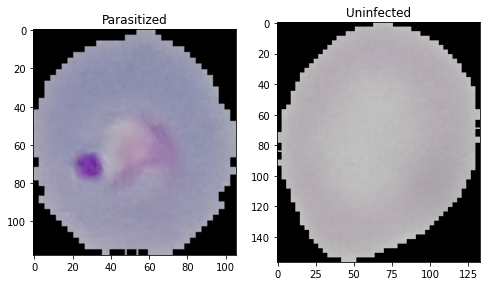

In [6]:
from PIL import Image
infected_dir = os.path.join('cell_images','Parasitized')
uninfected_dir = os.path.join('cell_images','Uninfected')

# select random infected pic
rand_norm = np.random.randint(0, len(os.listdir(infected_dir)))
infected_pic = os.listdir(infected_dir)[rand_norm]
infected_pic_address = os.path.join('cell_images','Parasitized',infected_pic)

# select random uninfected pic
rand_norm = np.random.randint(0, len(os.listdir(uninfected_dir)))
uninfected_pic = os.listdir(uninfected_dir)[rand_norm]
uninfected_pic_address = os.path.join('cell_images','Uninfected',uninfected_pic)

# load the images
infected_load = Image.open(infected_pic_address)
uninfected_load = Image.open(uninfected_pic_address)

# plot the images
f = plt.figure(figsize= (8,8))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(infected_load, cmap='gray')
a1.set_title('Parasitized');

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(uninfected_load, cmap='gray')
a2.set_title('Uninfected');

In [7]:
# Libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
import logging
tf.get_logger().setLevel(logging.ERROR)

In [8]:
model = Sequential()

# convolution & pooling layers
model.add(Conv2D(
    filters=16,                    
    kernel_size=(3,3),              
    padding='same',
    activation=tf.nn.relu,
    input_shape=(120,120,3)
))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(
    filters=32,                    
    kernel_size=(3,3),              
    padding='same',
    activation=tf.nn.relu
))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(
    filters=64,                    
    kernel_size=(3,3),              
    padding='same',
    activation=tf.nn.relu
))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

# fully connected layers
model.add(Flatten())
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1

In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [10]:
len(train_gen)*32

22336

In [11]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    verbose=1
)

Epoch 1/10
698/698 [==============================] - 1377s 2s/step - loss: 0.5491 - acc: 0.7069 - val_loss: 0.3189 - val_acc: 0.8847
Epoch 2/10
698/698 [==============================] - 1115s 2s/step - loss: 0.2328 - acc: 0.9257 - val_loss: 0.2140 - val_acc: 0.9101
Epoch 3/10
698/698 [==============================] - 1074s 2s/step - loss: 0.1938 - acc: 0.9404 - val_loss: 0.2189 - val_acc: 0.9097
Epoch 4/10
698/698 [==============================] - 1068s 2s/step - loss: 0.1734 - acc: 0.9498 - val_loss: 0.2114 - val_acc: 0.9226
Epoch 5/10
698/698 [==============================] - 979s 1s/step - loss: 0.1667 - acc: 0.9497 - val_loss: 0.2164 - val_acc: 0.9214
Epoch 6/10
698/698 [==============================] - 1073s 2s/step - loss: 0.1617 - acc: 0.9528 - val_loss: 0.2058 - val_acc: 0.9258
Epoch 7/10
698/698 [==============================] - 1121s 2s/step - loss: 0.1586 - acc: 0.9535 - val_loss: 0.2381 - val_acc: 0.9173
Epoch 8/10
698/698 [==============================] - 1088s 2s/

In [12]:
def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history['acc'])
    plt.plot(epochRange,history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(epochRange,history.history['loss'])
    plt.plot(epochRange,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

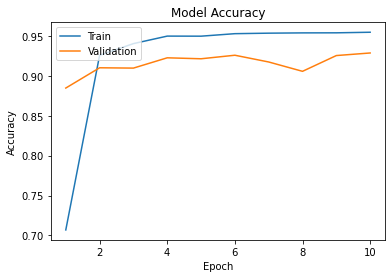

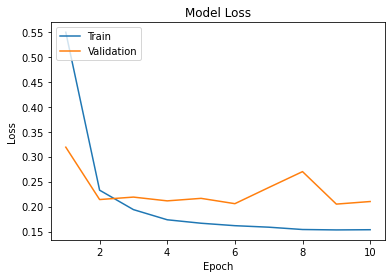

In [13]:
plotLearningCurve(history,10)

In [14]:
model.evaluate(
    x=test_gen,
    verbose=1
)

87/87 [==============================] - 45s 522ms/step - loss: 0.1661 - acc: 0.9554


[0.16610246681843766, 0.9553701]